# RNN循环神经网络

# 循环核：
**循环核：是通过不同时刻的参数共享，能实现时间序列的信息提取的具有记忆力的核心。**
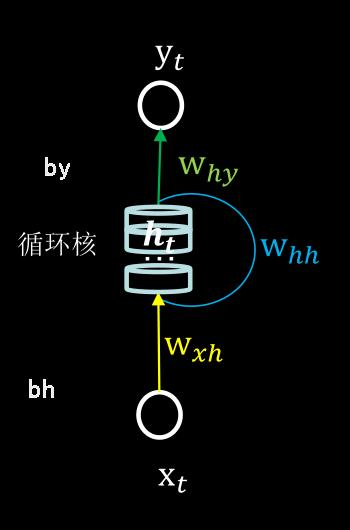

$$\mbox{循环层公式：}h_t = tanh(x_tw_{xh}+h_{t-1}w_{hh}+bh)$$
$$\mbox{输出层公式：}y_t = softmax(h_tw_{hy}+by)$$  
训练时（反向传播）：参数矩阵Wxh Whh Why Bh By被梯度下降法 更新。  
预测时（前向传播）：参数矩阵Wxh Whh Why Bh By 都是固定不变的。  

### 一、循环核（单个） 按时间步骤展开
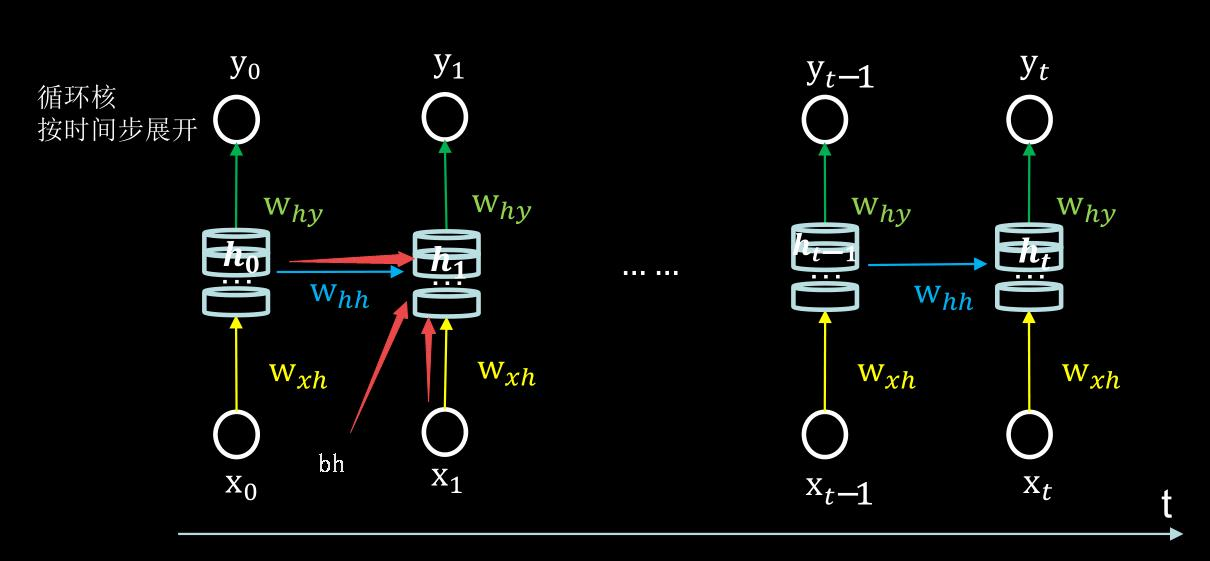

### 二、循环核（多个） 按输出步骤展开
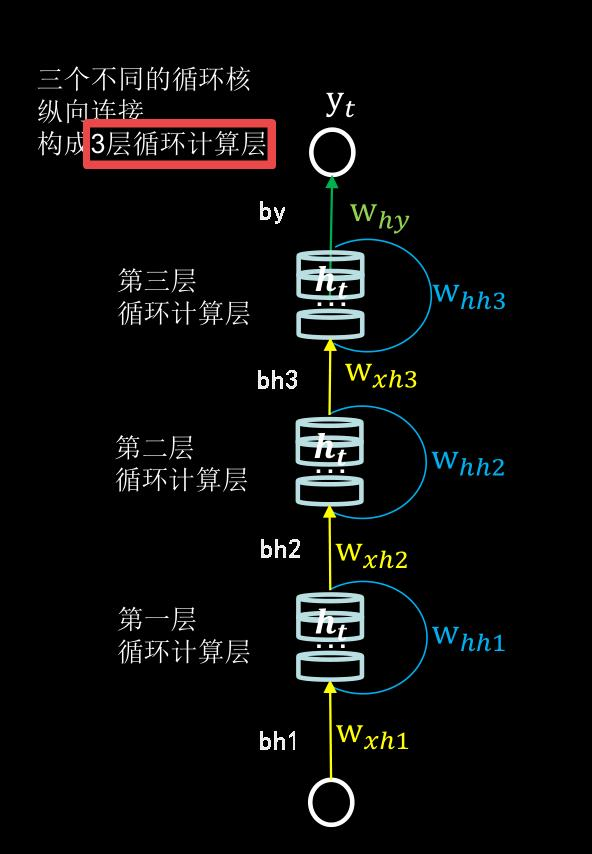

# 循环核 的代码表述SimpleRNN()
tf.keras.layers.SimpleRNN(  
$~~~~$记忆体个数,  
$~~~~$activation="激活函数", 默认"tanh"  
$~~~~$return_sequences= 是否 每个时刻都输出ht到下一层  
)  

*return_sequences=True  每个时间步都输出ht到下一层*  
*return_sequences=False  仅最后时间步输出ht（默认）*  
*我们通常在多循环核的最后一个循环核使用return_sequences=True*  

例子：  
*SimpleRNN(3, activation=tanh, return_sequences=True)*
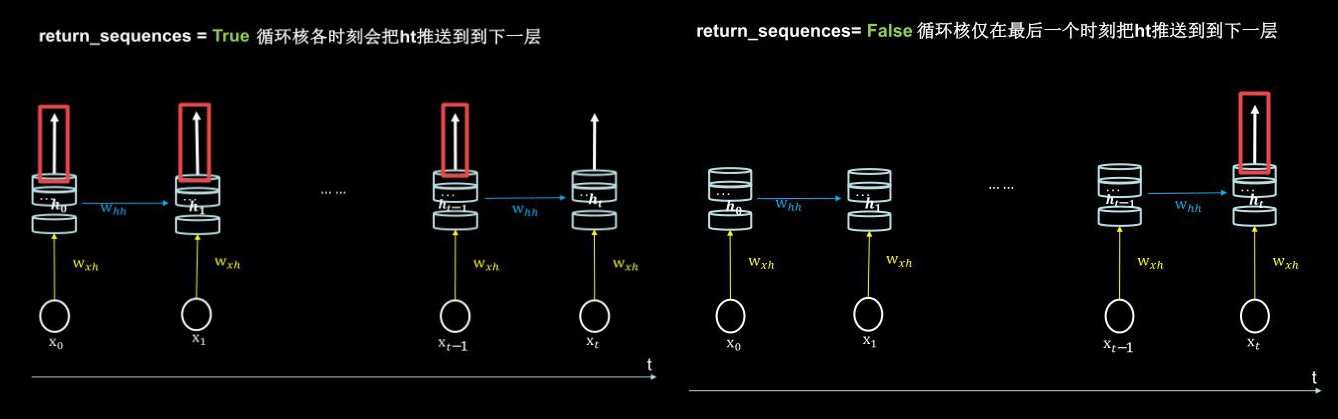

### SimpleRNN()对输入数据（x_train）的维度有特殊要求
**x_train.shape → 【送入样本数, 循环核时间展开步数, 每个时间步输入特征个数】**
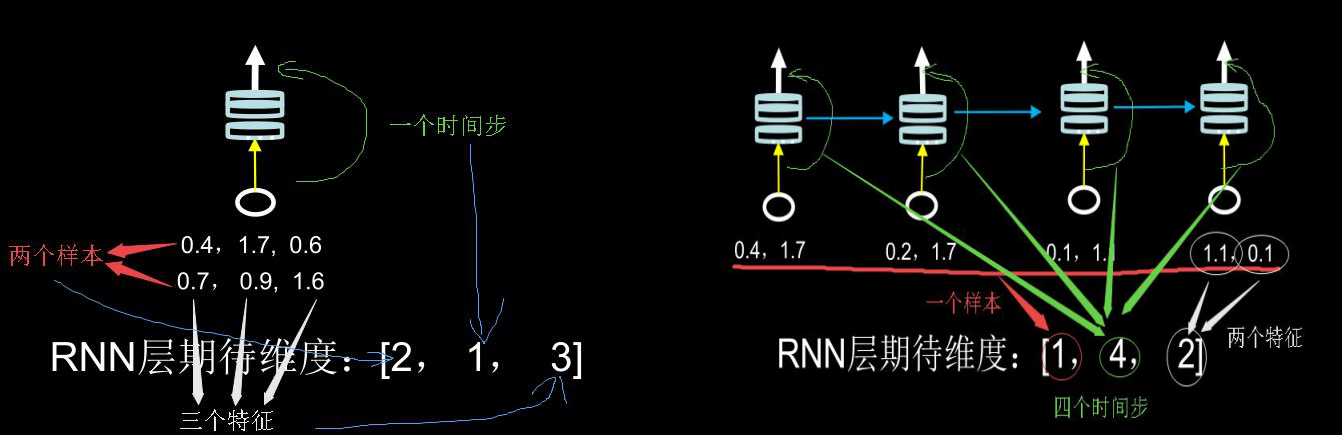

# 手算实现字母预测
字母预测：  
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$*输入a预测出b，*  
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$*输入b预测出c，*  
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$*输入c预测出d，*  
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$*输入d预测出e，*  
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$*输入e预测出a。*  
转化为独热码：  

|字母|独热码|
|:---:|:---:|
|a|10000|
|b|01000|
|c|00100|
|d|00010|
|e|00001|

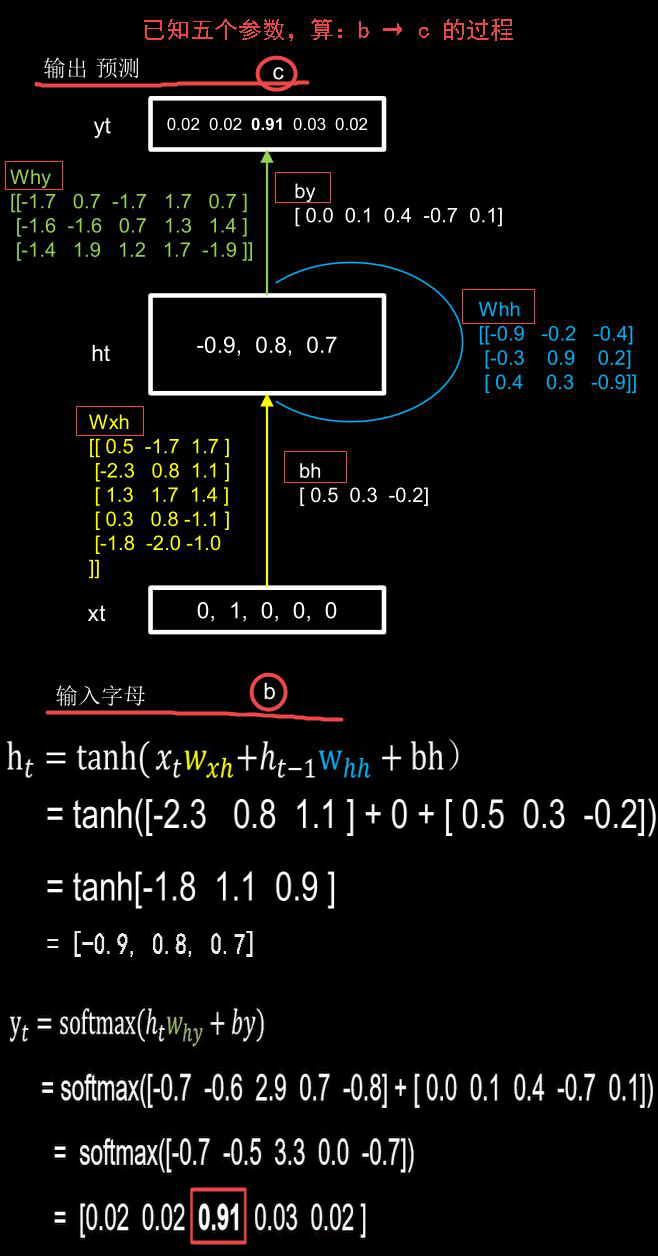

# ①RNN网络实现单个字母预测单个字母（独热码）

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt
import os
# np.set_printoptions(threshold=np.inf) # 超过多少省略打印

In [ ]:
x_train = [1,2,3,4,5]
y_train = ['一','二','三','四','五']
np.random.seed(15)
np.random.shuffle(x_train)
np.random.seed(15)
np.random.shuffle(y_train)
print(x_train)
print(y_train)

In [ ]:
# *************************    RNN网络-单字母预测单字母     **************************
# =============================        1.import          =============================
# 略
# =============================     2.测试集、训练集     =============================
word = 'abcde'
word2id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4} # 字母先映射到数值
id2onehot = { # 数值映射到独热码
    0 : [1., 0., 0., 0., 0.], 
    1 : [0., 1., 0., 0., 0.], 
    2 : [0., 0., 1., 0., 0.], 
    3 : [0., 0., 0., 1., 0.], 
    4 : [0., 0., 0., 0., 1.]
}
x_train = [
    id2onehot[word2id['a']], # [1., 0., 0., 0., 0.]
    id2onehot[word2id['b']], # [0., 1., 0., 0., 0.]
    id2onehot[word2id['c']], # [0., 0., 1., 0., 0.]
    id2onehot[word2id['d']], # [0., 0., 0., 1., 0.]
    id2onehot[word2id['e']]  # [0., 0., 0., 0., 1.]
]
y_train = [
    word2id['b'], # 1
    word2id['c'], # 2
    word2id['d'], # 3
    word2id['e'], # 4
    word2id['a']  # 0
]
# 同顺序随机打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)

# 使x_train符合SimpalRNN()要求的维度
x_train = np.reshape(x_train,( len(x_train), 1, 5 )) # 'abcde'5个样本，一个时间步，[1,0,0,0,0]五个特征
y_train = np.array(y_train)

# ==============================  3.循环神经网络的搭建  ==============================
model = tf.keras.Sequential(
    [
    SimpleRNN(
        3, # 记忆体个数
        activation='tanh', # 激活函数
        return_sequences=False # 是否 每个时刻都输出ht到下一层
             ), 
    Dense(5, activation='softmax')
    ] # ！！！！！！！！！！这个中括号老是忘！！！！！！！！！！！！
)

# =============================    4.Compile 配置训练方法   ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy'] 
)

# =============================      5.断点续训     ==========================
checkpoint_save_path = '../class6/checkpoint/RNN_a2b.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------------------读取已存模型----------------------------')
    model.load_weights(checkpoint_save_path)
    
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_save_path,
    save_weights_only = True,
    save_best_only = True,
    monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, 
                    callbacks=[ckpt_callback])

# ==========================  6.summary 打印网络结构和参数统计  ======================
model.summary()

# =============================  7.参数提取，把参数存入文本  =========================
file = open('../class6/checkpoint/RNN_a2b_weights.txt', 'w')
# print(model.trainable_variables) # 打印所有可训练参数
for v in model.trainable_variables: # 将参数写入txt文本
   file.write(str(v.name) + '\n')
   file.write(str(v.shape) + '\n')
   file.write(str(v.numpy()) + '\n')
file.close()

# =============================  8.显示训练集的acc和loss曲线  ========================
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='训练集准确率')
plt.title('准确率')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='训练集误差')
plt.title('误差')
plt.legend()
plt.show()
# =================================  9.手动输入字母测试  =============================
print('******** 验证 ********')
for alphabet in 'abcde':
    hotkey = [id2onehot[word2id[alphabet]]]
    hotkey = np.reshape(hotkey, (1,1,5))
    predict_result = model.predict(hotkey) # model.predict()函数
    result = int(tf.argmax(predict_result, axis=1))
    print('输入 {} ，预测结果为：=====> {}'.format(alphabet, word[result]))
        

# ②RNN网络实现多个字母预测单个字母（独热码）
**手算过程：**
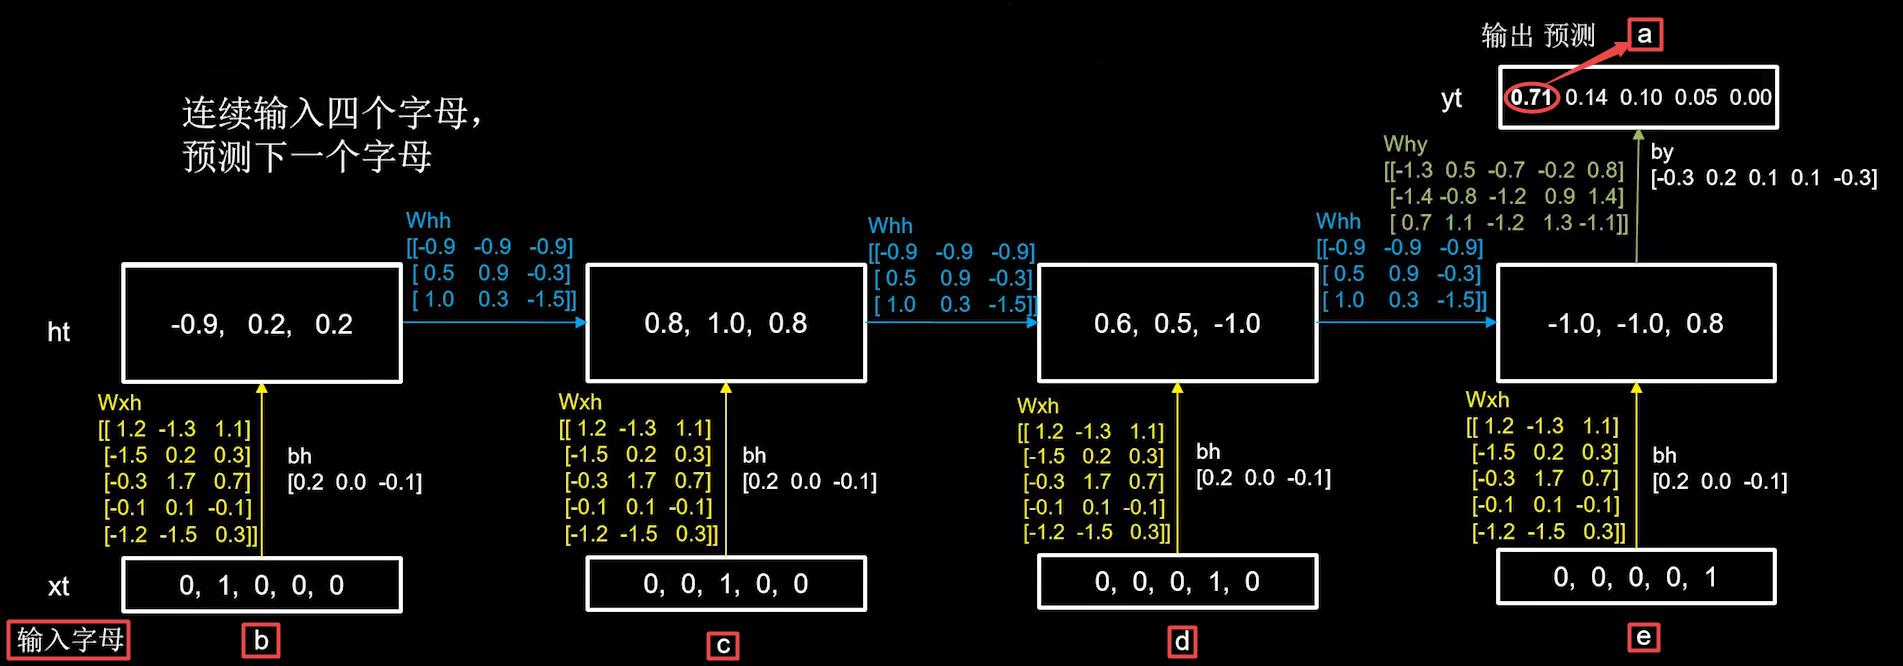

In [ ]:
# *************************    RNN网络-多字母预测单字母     **************************
# =============================        1.import          =============================
# 略
# =============================     2.测试集、训练集     =============================
word = 'abcde'
word2id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4} # 字母先映射到数值
id2onehot = { # 数值映射到独热码
    0 : [1., 0., 0., 0., 0.], 
    1 : [0., 1., 0., 0., 0.], 
    2 : [0., 0., 1., 0., 0.], 
    3 : [0., 0., 0., 1., 0.], 
    4 : [0., 0., 0., 0., 1.]
}
x_train = [
    [id2onehot[word2id['a']],id2onehot[word2id['b']],id2onehot[word2id['c']],id2onehot[word2id['d']]],
    [id2onehot[word2id['b']],id2onehot[word2id['c']],id2onehot[word2id['d']],id2onehot[word2id['e']]],
    [id2onehot[word2id['c']],id2onehot[word2id['d']],id2onehot[word2id['e']],id2onehot[word2id['a']]],
    [id2onehot[word2id['d']],id2onehot[word2id['e']],id2onehot[word2id['a']],id2onehot[word2id['b']]],
    [id2onehot[word2id['e']],id2onehot[word2id['a']],id2onehot[word2id['b']],id2onehot[word2id['c']]]
]
y_train = [
    word2id['e'],
    word2id['a'],
    word2id['b'],
    word2id['c'],
    word2id['d']
]
# 同顺序随机打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)

# 使x_train符合SimpalRNN()要求的维度
x_train = np.reshape(x_train,( len(x_train), 4, 5 )) # 'abcde'5个样本，4个时间步，[1,0,0,0,0]五个特征
y_train = np.array(y_train)

# ==============================  3.循环神经网络的搭建  ==============================
model = tf.keras.Sequential(
    [
    SimpleRNN(
        3, # 记忆体个数
        activation='tanh', # 激活函数
        return_sequences=False # 是否 每个时刻都输出ht到下一层
             ), 
    Dense(5, activation='softmax')
    ] # ！！！！！！！！！！这个中括号老是忘！！！！！！！！！！！！
)

# =============================    4.Compile 配置训练方法   ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy'] 
)

# =============================      5.断点续训     ==========================
checkpoint_save_path = '../class6/checkpoint/RNN_abcd2e.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------------------读取已存模型----------------------------')
    model.load_weights(checkpoint_save_path)
    
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_save_path,
    save_weights_only = True,
    save_best_only = True,
    monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, 
                    callbacks=[ckpt_callback])

# ==========================  6.summary 打印网络结构和参数统计  ======================
model.summary()

# =============================  7.参数提取，把参数存入文本  =========================
file = open('../class6/checkpoint/RNN_abcd2e_weights.txt', 'w')
# print(model.trainable_variables) # 打印所有可训练参数
for v in model.trainable_variables: # 将参数写入txt文本
   file.write(str(v.name) + '\n')
   file.write(str(v.shape) + '\n')
   file.write(str(v.numpy()) + '\n')
file.close()

# =============================  8.显示训练集的acc和loss曲线  ========================
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='训练集准确率')
plt.title('准确率')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='训练集误差')
plt.title('误差')
plt.legend()
plt.show()
# =================================  9.手动输入字母测试  =============================
print('******** 验证 ********')
for alphabet in ['abcd', 'bcde', 'cdea', 'deab', 'eabc']:
    hotkey = []
    for i in alphabet:
        hotkey.append([id2onehot[word2id[i]]])
    hotkey = np.reshape(hotkey, (1,4,5))
    predict_result = model.predict(hotkey) # model.predict()函数
    result = int(tf.argmax(predict_result, axis=1))
    print('输入 {} ，预测结果为：=====> {}'.format(alphabet, word[result]))

# Embedding编码
~~*当使用独热码时，26个英文字母需要26位宽的独热码。这导致数据量偏大，映射之间过于独立，没有表现出关联性。*~~  
Embedding：是种"低维向量"实现的编码，这种编码通过神经网络训练优化，能表达出单词间的相关性。
* **tf.keras.layers.Embedding**(词汇表大小，编码维度)  

**参数：**  
*词汇表大小： 需要编码几个单词？*  
*编码维度： 需要几个数字表达一个单词？*  
**例子：**  
*对1-100进行编码，"1"的编码为：[0.77, 0.12, 0.51]$~~$ → $~~$tf.keras.layers.Embedding(100, 3)*  
**对x_train的维度要求：**  
<font color='red'>Embedding要求的维度：[送入样本数， 循环核时间展开步数]</font>

# ③RNN单个字母预测单个字母（Embedding编码）

In [ ]:
# *************************    RNN网络-单字母预测单字母     **************************
# =============================        1.import          =============================

from tensorflow.keras.layers import Embedding

# =============================     2.测试集、训练集     =============================
word = 'abcde'
word2id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4} # 字母先映射到数值

x_train = [word2id['a'], word2id['b'], word2id['c'], word2id['d'], word2id['e']]
y_train = [word2id['b'], word2id['c'], word2id['d'], word2id['e'], word2id['a']]

# 同顺序随机打乱
np.random.seed(51)
np.random.shuffle(x_train)
np.random.seed(51)
np.random.shuffle(y_train)

# 使x_train符合Embedding要求的维度
x_train = np.reshape(x_train,( len(x_train), 1)) # 'abcde'5个样本，一个时间步
y_train = np.array(y_train)

# ==============================  3.循环神经网络的搭建  ==============================
model = tf.keras.Sequential(
    [
    # 添加一个Embedding层，生成一个可训练矩阵，用来编码原数据
    Embedding(5, 2), # 需要编码5个单词；用2个数字表达一个单词。
    
    SimpleRNN(3), 
    Dense(5, activation='softmax')
    ] # ！！！！！！！！！！这个中括号老是忘！！！！！！！！！！！！
)

# =============================    4.Compile 配置训练方法   ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy'] 
)

# =============================      5.断点续训     ==========================
checkpoint_save_path = '../class6/checkpoint/RNN_a2b_Embedding.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------------------读取已存模型----------------------------')
    model.load_weights(checkpoint_save_path)
    
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_save_path,
    save_weights_only = True,
    save_best_only = True,
    monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, 
                    callbacks=[ckpt_callback])

# ==========================  6.summary 打印网络结构和参数统计  ======================
model.summary()

# =============================  7.参数提取，把参数存入文本  =========================
file = open('../class6/checkpoint/RNN_a2b_Embedding_weights.txt', 'w')
# print(model.trainable_variables) # 打印所有可训练参数
for v in model.trainable_variables: # 将参数写入txt文本
   file.write(str(v.name) + '\n')
   file.write(str(v.shape) + '\n')
   file.write(str(v.numpy()) + '\n')
file.close()

# =============================  8.显示训练集的acc和loss曲线  ========================
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='训练集准确率')
plt.title('准确率')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='训练集误差')
plt.title('误差')
plt.legend()
plt.show()
# =================================  9.手动输入字母测试  =============================
print('******** 验证 ********')
for alphabet in 'abcde':
    hotkey = word2id[alphabet]
    hotkey = np.reshape(hotkey, (1,1))
    predict_result = model.predict(hotkey) # model.predict()函数
    result = int(tf.argmax(predict_result, axis=1))
    print('输入 {} ，预测结果为：=====> {}'.format(alphabet, word[result]))

# ④RNN多个字母预测单个字母（Embedding编码）

In [ ]:
# *************************    RNN网络-多字母预测单字母     **************************
# =============================        1.import          =============================
# 略
# =============================     2.测试集、训练集     =============================
word = 'abcde'
word2id = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4} # 字母先映射到数值

x_train = [
    [word2id['a'], word2id['b'], word2id['c'], word2id['d']],
    [word2id['b'], word2id['c'], word2id['d'], word2id['e']],
    [word2id['c'], word2id['d'], word2id['e'], word2id['a']],
    [word2id['d'], word2id['e'], word2id['a'], word2id['b']],
    [word2id['e'], word2id['a'], word2id['b'], word2id['c']]
]
y_train = [word2id['e'], word2id['a'], word2id['b'], word2id['c'], word2id['d']]


# 同顺序随机打乱
np.random.seed(78)
np.random.shuffle(x_train)
np.random.seed(78)
np.random.shuffle(y_train)

# 使x_train符合Embedding()要求的维度
x_train = np.reshape(x_train,( len(x_train), 4)) # 'abcd'等5个样本，4个时间步
y_train = np.array(y_train)

# ==============================  3.循环神经网络的搭建  ==============================
model = tf.keras.Sequential(
    [
    # 添加一个Embedding层，生成一个可训练矩阵，用来编码原数据
    Embedding(5, 2), # 需要编码5个单词；用2个数字表达一个单词。
    SimpleRNN(3), 
    Dense(5, activation='softmax')
    ] # ！！！！！！！！！！这个中括号老是忘！！！！！！！！！！！！
)

# =============================    4.Compile 配置训练方法   ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy'] 
)

# =============================      5.断点续训     ==========================
checkpoint_save_path = '../class6/checkpoint/RNN_abcd2e_Embedding.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------------------读取已存模型----------------------------')
    model.load_weights(checkpoint_save_path)
    
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_save_path,
    save_weights_only = True,
    save_best_only = True,
    monitor='loss')  # 由于fit没有给出测试集，不计算测试集准确率，根据loss，保存最优模型

history = model.fit(x_train, y_train, batch_size=32, epochs=100, 
                    callbacks=[ckpt_callback])

# ==========================  6.summary 打印网络结构和参数统计  ======================
model.summary()

# =============================  7.参数提取，把参数存入文本  =========================
file = open('../class6/checkpoint/RNN_abcd2e_Embedding_weights.txt', 'w')
# print(model.trainable_variables) # 打印所有可训练参数
for v in model.trainable_variables: # 将参数写入txt文本
   file.write(str(v.name) + '\n')
   file.write(str(v.shape) + '\n')
   file.write(str(v.numpy()) + '\n')
file.close()

# =============================  8.显示训练集的acc和loss曲线  ========================
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

acc = history.history['sparse_categorical_accuracy']
loss = history.history['loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='训练集准确率')
plt.title('准确率')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='训练集误差')
plt.title('误差')
plt.legend()
plt.show()
# =================================  9.手动输入字母测试  =============================
print('******** 验证 ********')
for alphabet in ['abcd', 'bcde', 'cdea', 'deab', 'eabc']:
    hotkey = []
    for i in alphabet:
        hotkey.append([word2id[i]])
    hotkey = np.reshape(hotkey, (1,4))
    predict_result = model.predict(hotkey) # model.predict()函数
    result = int(tf.argmax(predict_result, axis=1))
    print('输入 {} ，预测结果为：=====> {}'.format(alphabet, word[result]))


# 用tushare下载股票数据

# 用RNN实现股票预测

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

-------------读取已存模型-----------------
Train on 2069 samples, validate on 239 samples
Epoch 1/50
2069/2069 [==============================] - 2s 832us/sample - loss: 7.8559e-04 - val_loss: 0.0011
Epoch 2/50
2069/2069 [==============================] - 1s 342us/sample - loss: 6.9690e-04 - val_loss: 0.0032
Epoch 3/50
2069/2069 [==============================] - 1s 379us/sample - loss: 7.4910e-04 - val_loss: 0.0034
Epoch 4/50
2069/2069 [==============================] - 1s 322us/sample - loss: 7.1133e-04 - val_loss: 0.0015
Epoch 5/50
2069/2069 [==============================] - 1s 318us/sample - loss: 6.8489e-04 - val_loss: 0.0016
Epoch 6/50
2069/2069 [==============================] - 1s 344us/sample - loss: 6.5518e-04 - val_loss: 0.0024
Epoch 7/50
2069/2069 [==============================] - 1s 330us/sample - loss: 6.6040e-04 - val_loss: 0.0012
Epoch 8/50
2069/2069 [==============================] - 1s 327us/sample - loss: 6.9709e-04 - val_loss: 0.0028
Epoch 9/50
2069/2069 [==============

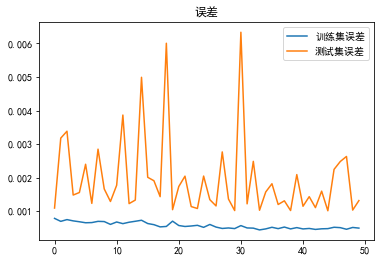

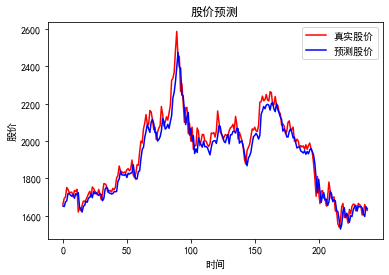

均方误差: 3015.893583
均方根误差: 54.917152
平均绝对误差: 42.257251


In [4]:
# ****************************    RNN网络-实现股票预测    ****************************
# =============================        1.import          =============================

# =============================     2.测试集、训练集     =============================

df = pd.read_csv('../class6/SH600519.csv')

# 1.截取数据
train_set = df.iloc[0:2429-300, 2:3].values # 前(2426-300=2126)天的开盘价作为训练集
test_set = df.iloc[2429-300:,2:3].values # 后300天的开盘价作为测试集

# 2.归一化
mms = MinMaxScaler(feature_range=(0,1)) # 调用sklearn.preprocessing中的尺度器定义归一化：归一化到(0，1)之间
train_set = mms.fit_transform(train_set) # 转换训练集的尺度为（0 - 1）
test_set = mms.transform(test_set) # 利用训练集的属性对测试集进行归一化


# 3.提取x数据、y数据
x_train, y_train, x_test, y_test = [], [], [], []
# 3.1训练集：利用for循环，遍历提取连续60天的开盘价作为输入特征x_train，第61天的数据作为标签
for i in range(60, len(train_set)):
    x_train.append(train_set[i-60 : i, 0]) 
    y_train.append(train_set[i, 0]) # 这里加“0”切片出来就不是array
# 3.1.1同顺序随机打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 3.1.2将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
# 3.1.3使x_train符合SimpalRNN()要求的维度
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1)) # 此时len(x_train),x_train.shape[0] == (2069, 2069)

# 3.2测试集：利用for循环，遍历提取连续60天的开盘价作为输入特征x_train，第61天的数据作为标签
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 3.2.1将测试集由list格式变为array格式
x_test, y_test = np.array(x_test), np.array(y_test)
# 3.2.2使x_test符合SimpalRNN()要求的维度
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

# ==============================  3.循环神经网络的搭建  ==============================
model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])

# =============================    4.Compile 配置训练方法   ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_error'
    # metrics=['sparse_categorical_accuracy'] 
    # 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
)

# =============================      5.断点续训     ==========================
checkpoint_save_path = "../class6/checkpoint/RNN_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------读取已存模型-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, 
                    validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

# ==========================  6.summary 打印网络结构和参数统计  ======================
model.summary()

# =============================  7.参数提取，把参数存入文本  =========================
file = open('../class6/checkpoint/RNN_stock_weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

# =============================  8.显示训练集的loss曲线  =========================
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='训练集误差')
plt.plot(val_loss, label='测试集误差')
plt.title('误差')
plt.legend()
plt.show()
# =================================  9.预测与对比  =============================
predicted_stock_price = model.predict(x_test) # 测试集输入模型 进行预测
predicted_stock_price = mms.inverse_transform(predicted_stock_price) # 反归一化到原始范围
real_stock_price = mms.inverse_transform(test_set[60:]) # 反归一化到原始范围

# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='真实股价')
plt.plot(predicted_stock_price, color='blue', label='预测股价')
plt.title('股价预测')
plt.xlabel('时间')
plt.ylabel('股价')
plt.legend()
plt.show()

# =================================  9.模型效果评价  =============================

# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

# 用LSTM实现股票预测
LSTM能有效缓解由于时间步过长导致的梯度消失问题  
**tf.keras.layers.LSTM( 记忆体个数，return_sequences= 是否返回输出)**  
*return_sequences=True 各时间步输出ht*  
*return_sequences=False  仅最后时间步输出ht（默认）*  
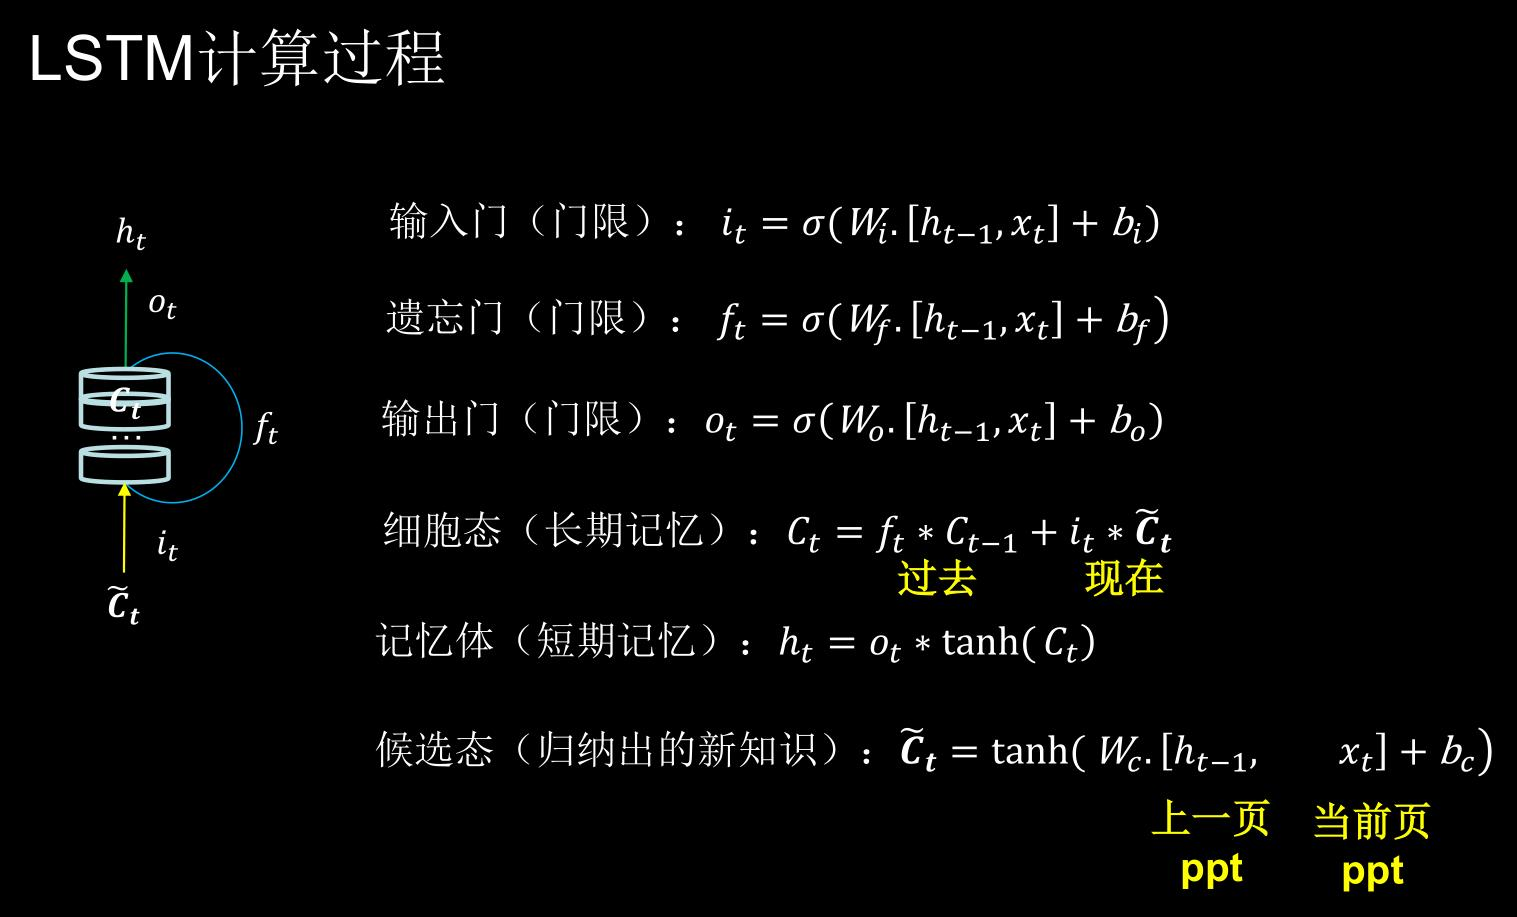

Train on 2069 samples, validate on 239 samples
Epoch 1/50
2069/2069 [==============================] - 4s 2ms/sample - loss: 0.0102 - val_loss: 0.0161
Epoch 2/50
2069/2069 [==============================] - 3s 1ms/sample - loss: 0.0010 - val_loss: 0.0080
Epoch 3/50
2069/2069 [==============================] - 3s 1ms/sample - loss: 8.1158e-04 - val_loss: 0.0050
Epoch 4/50
2069/2069 [==============================] - 3s 1ms/sample - loss: 7.2306e-04 - val_loss: 0.0041
Epoch 5/50
2069/2069 [==============================] - 3s 1ms/sample - loss: 7.0552e-04 - val_loss: 0.0048
Epoch 6/50
2069/2069 [==============================] - 3s 1ms/sample - loss: 6.5987e-04 - val_loss: 0.0040
Epoch 7/50
2069/2069 [==============================] - 3s 1ms/sample - loss: 7.3829e-04 - val_loss: 0.0044
Epoch 8/50
2069/2069 [==============================] - 3s 1ms/sample - loss: 6.6288e-04 - val_loss: 0.0047
Epoch 9/50
2069/2069 [==============================] - 3s 1ms/sample - loss: 6.2295e-04 - val_lo

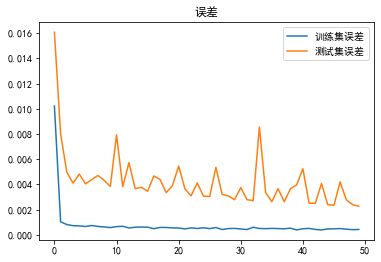

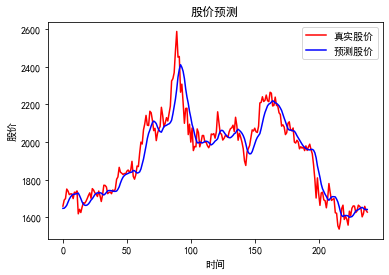

均方误差: 5183.654708
均方根误差: 71.997602
平均绝对误差: 51.617809


In [7]:
# ****************************    LSTM网络-实现股票预测    ****************************
# =============================        1.import          =============================
from tensorflow.keras.layers import LSTM
# =============================     2.测试集、训练集     =============================

df = pd.read_csv('../class6/SH600519.csv')

# 1.截取数据
train_set = df.iloc[0:2429-300, 2:3].values # 前(2426-300=2126)天的开盘价作为训练集
test_set = df.iloc[2429-300:,2:3].values # 后300天的开盘价作为测试集

# 2.归一化
mms = MinMaxScaler(feature_range=(0,1)) # 调用sklearn.preprocessing中的尺度器定义归一化：归一化到(0，1)之间
train_set = mms.fit_transform(train_set) # 转换训练集的尺度为（0 - 1）
test_set = mms.transform(test_set) # 利用训练集的属性对测试集进行归一化


# 3.提取x数据、y数据
x_train, y_train, x_test, y_test = [], [], [], []
# 3.1训练集：利用for循环，遍历提取连续60天的开盘价作为输入特征x_train，第61天的数据作为标签
for i in range(60, len(train_set)):
    x_train.append(train_set[i-60 : i, 0]) 
    y_train.append(train_set[i, 0]) # 这里加“0”切片出来就不是array
# 3.1.1同顺序随机打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 3.1.2将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
# 3.1.3使x_train符合SimpalRNN()要求的维度
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1)) # 此时len(x_train),x_train.shape[0] == (2069, 2069)

# 3.2测试集：利用for循环，遍历提取连续60天的开盘价作为输入特征x_train，第61天的数据作为标签
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 3.2.1将测试集由list格式变为array格式
x_test, y_test = np.array(x_test), np.array(y_test)
# 3.2.2使x_test符合SimpalRNN()要求的维度
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

# ==============================  3.循环神经网络的搭建  ==============================
model = tf.keras.Sequential([
    # *********************  改动  ************************
    # *********************  改动  ************************
    # *********************  改动  ************************
    LSTM(80, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
    # *********************  改动  ************************
    # *********************  改动  ************************
    # *********************  改动  ************************
])

# =============================    4.Compile 配置训练方法   ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_error'
    # metrics=['sparse_categorical_accuracy'] 
    # 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
)

# =============================      5.断点续训     ==========================
checkpoint_save_path = "../class6/checkpoint/LSTM_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------读取已存模型-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, 
                    validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

# ==========================  6.summary 打印网络结构和参数统计  ======================
model.summary()

# =============================  7.参数提取，把参数存入文本  =========================
file = open('../class6/checkpoint/LSTM_stock_weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

# =============================  8.显示训练集的loss曲线  =========================
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='训练集误差')
plt.plot(val_loss, label='测试集误差')
plt.title('误差')
plt.legend()
plt.show()
# =================================  9.预测与对比  =============================
predicted_stock_price = model.predict(x_test) # 测试集输入模型 进行预测
predicted_stock_price = mms.inverse_transform(predicted_stock_price) # 反归一化到原始范围
real_stock_price = mms.inverse_transform(test_set[60:]) # 反归一化到原始范围

# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='真实股价')
plt.plot(predicted_stock_price, color='blue', label='预测股价')
plt.title('股价预测')
plt.xlabel('时间')
plt.ylabel('股价')
plt.legend()
plt.show()

# =================================  9.模型效果评价  =============================

# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

# 用GRU实现股票预测
GRU由Cho等人于2014年提出，优化LSTM结构。  
**tf.keras.layers.GRU( 记忆体个数，return_sequences= 是否返回输出)**  
*return_sequences=True 各时间步输出ht*  
*return_sequences=False  仅最后时间步输出ht（默认）*  
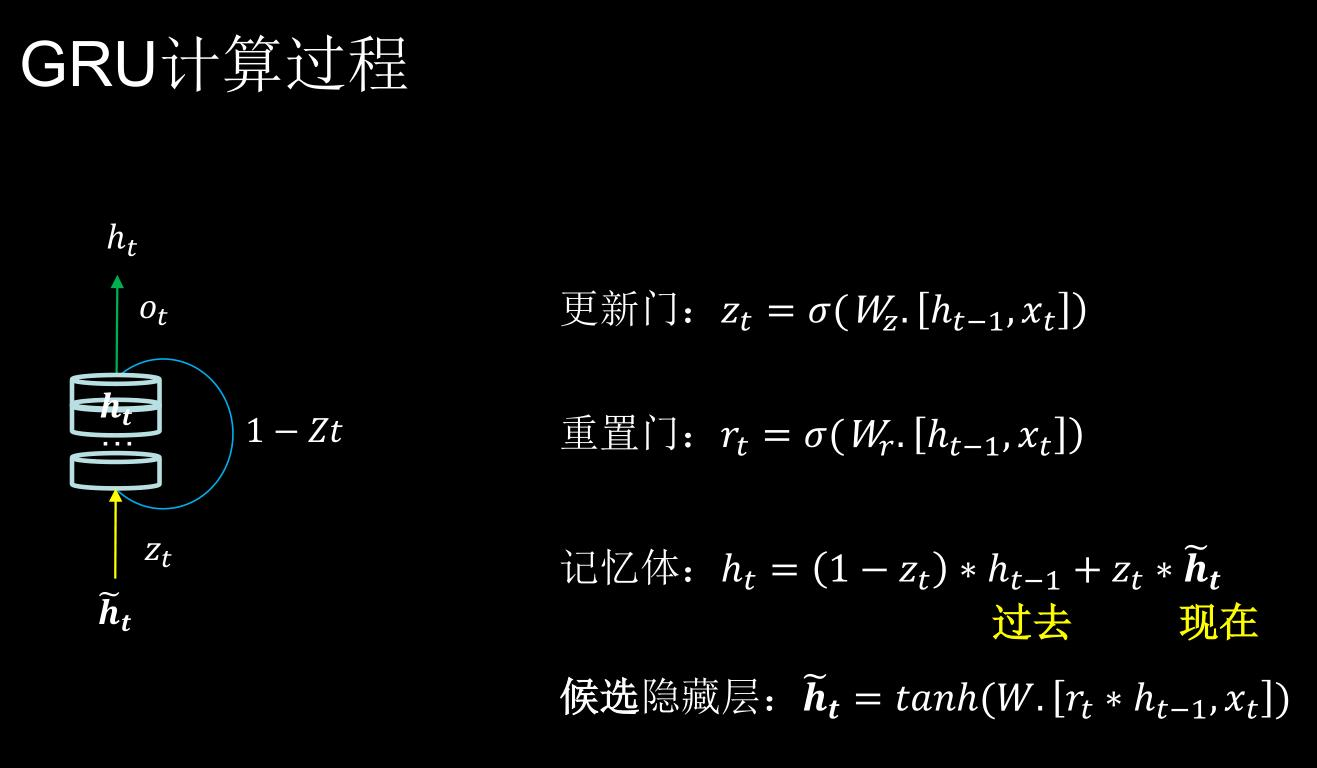

Train on 2069 samples, validate on 239 samples
Epoch 1/50
2069/2069 [==============================] - 4s 2ms/sample - loss: 0.0139 - val_loss: 0.0020
Epoch 2/50
2069/2069 [==============================] - 2s 1ms/sample - loss: 9.5928e-04 - val_loss: 0.0020
Epoch 3/50
2069/2069 [==============================] - 2s 1ms/sample - loss: 8.2880e-04 - val_loss: 0.0027
Epoch 4/50
2069/2069 [==============================] - 2s 1ms/sample - loss: 6.8401e-04 - val_loss: 0.0023
Epoch 5/50
2069/2069 [==============================] - 2s 1ms/sample - loss: 6.5498e-04 - val_loss: 0.0020
Epoch 6/50
2069/2069 [==============================] - 2s 1ms/sample - loss: 6.3687e-04 - val_loss: 0.0030
Epoch 7/50
2069/2069 [==============================] - 2s 1ms/sample - loss: 6.2204e-04 - val_loss: 0.0021
Epoch 8/50
2069/2069 [==============================] - 2s 1ms/sample - loss: 5.6334e-04 - val_loss: 0.0018
Epoch 9/50
2069/2069 [==============================] - 2s 1ms/sample - loss: 5.7210e-04 - va

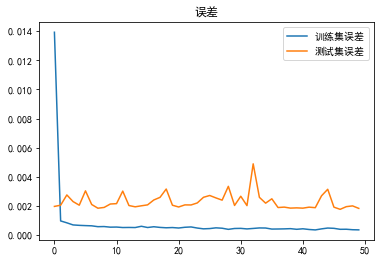

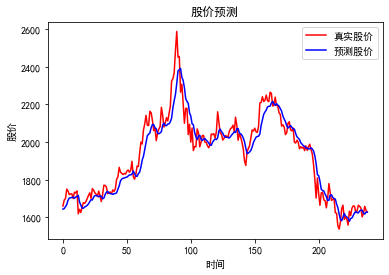

均方误差: 4174.554496
均方根误差: 64.610792
平均绝对误差: 47.211594


In [8]:
# ****************************    GRU网络-实现股票预测    ****************************
# =============================        1.import          =============================
from tensorflow.keras.layers import GRU
# =============================     2.测试集、训练集     =============================

df = pd.read_csv('../class6/SH600519.csv')

# 1.截取数据
train_set = df.iloc[0:2429-300, 2:3].values # 前(2426-300=2126)天的开盘价作为训练集
test_set = df.iloc[2429-300:,2:3].values # 后300天的开盘价作为测试集

# 2.归一化
mms = MinMaxScaler(feature_range=(0,1)) # 调用sklearn.preprocessing中的尺度器定义归一化：归一化到(0，1)之间
train_set = mms.fit_transform(train_set) # 转换训练集的尺度为（0 - 1）
test_set = mms.transform(test_set) # 利用训练集的属性对测试集进行归一化


# 3.提取x数据、y数据
x_train, y_train, x_test, y_test = [], [], [], []
# 3.1训练集：利用for循环，遍历提取连续60天的开盘价作为输入特征x_train，第61天的数据作为标签
for i in range(60, len(train_set)):
    x_train.append(train_set[i-60 : i, 0]) 
    y_train.append(train_set[i, 0]) # 这里加“0”切片出来就不是array
# 3.1.1同顺序随机打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 3.1.2将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
# 3.1.3使x_train符合SimpalRNN()要求的维度
x_train = np.reshape(x_train, (x_train.shape[0], 60, 1)) # 此时len(x_train),x_train.shape[0] == (2069, 2069)

# 3.2测试集：利用for循环，遍历提取连续60天的开盘价作为输入特征x_train，第61天的数据作为标签
for i in range(60, len(test_set)):
    x_test.append(test_set[i - 60:i, 0])
    y_test.append(test_set[i, 0])
# 3.2.1将测试集由list格式变为array格式
x_test, y_test = np.array(x_test), np.array(y_test)
# 3.2.2使x_test符合SimpalRNN()要求的维度
x_test = np.reshape(x_test, (x_test.shape[0], 60, 1))

# ==============================  3.循环神经网络的搭建  ==============================
model = tf.keras.Sequential([
    # *********************  改动  ************************
    # *********************  改动  ************************
    # *********************  改动  ************************
    GRU(80, return_sequences=True),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(1)
    # *********************  改动  ************************
    # *********************  改动  ************************
    # *********************  改动  ************************
])

# =============================    4.Compile 配置训练方法   ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_error'
    # metrics=['sparse_categorical_accuracy'] 
    # 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
)

# =============================      5.断点续训     ==========================
checkpoint_save_path = "../class6/checkpoint/GRU_stock.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------读取已存模型-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, 
                    validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

# ==========================  6.summary 打印网络结构和参数统计  ======================
model.summary()

# =============================  7.参数提取，把参数存入文本  =========================
file = open('../class6/checkpoint/GRU_stock_weights.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

# =============================  8.显示训练集的loss曲线  =========================
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='训练集误差')
plt.plot(val_loss, label='测试集误差')
plt.title('误差')
plt.legend()
plt.show()
# =================================  9.预测与对比  =============================
predicted_stock_price = model.predict(x_test) # 测试集输入模型 进行预测
predicted_stock_price = mms.inverse_transform(predicted_stock_price) # 反归一化到原始范围
real_stock_price = mms.inverse_transform(test_set[60:]) # 反归一化到原始范围

# 画出真实数据和预测数据的对比曲线
plt.plot(real_stock_price, color='red', label='真实股价')
plt.plot(predicted_stock_price, color='blue', label='预测股价')
plt.title('股价预测')
plt.xlabel('时间')
plt.ylabel('股价')
plt.legend()
plt.show()

# =================================  9.模型效果评价  =============================

# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)